In [124]:
# This code below is to se the structure of the code for Pyramidal Neuron - Larkum style
# Learning through target spikes

import numpy as np

from lttb import LTTB

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 5, 3, 1000
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)


sigma_targ = 10**1.5
sigma_in = 12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 10

JMAX = 100.
nu_targ = 0.005


# Here we init our (recurrent) agent
lttb = LTTB (par)


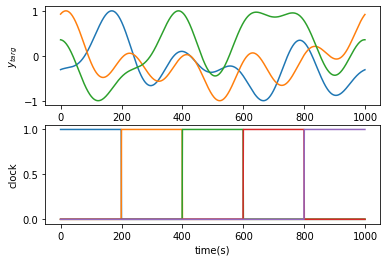

In [125]:
# define clock and target

lttb.init_targ(par)
lttb.init_clock(par)

plt.figure()
plt.subplot(211)
plt.plot(np.array(lttb.y_targ).T)
plt.ylabel('$y_{targ}$')
plt.subplot(212)
plt.plot(np.array(lttb.I_clock).T)
plt.xlabel('time(s)')
plt.ylabel('clock')
plt.show()


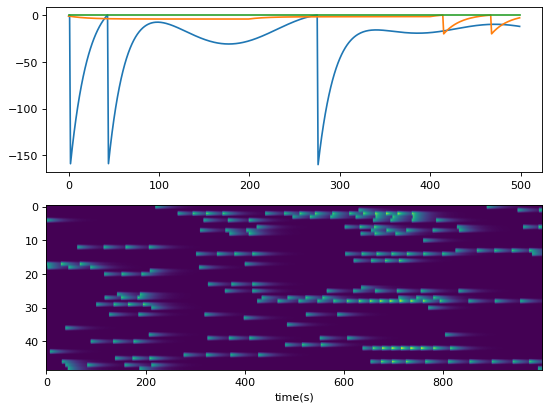

In [126]:
#initialize simulation

lttb.initialize(par)

#run simulation

for t in range(lttb.T-2):
    lttb.step(apicalFactor=1.)

#save target
S_apic_targ = lttb.S_apic_dist
B_targ = lttb.B_filt
    
ndx_plot = random.randint(0,lttb.N)

#plt.imshow(lttb.Vapic)
plt.figure(figsize=(8, 6), dpi=80)

plt.subplot(211)

plt.plot(lttb.Vapic[ndx_plot,0:500])
plt.plot(lttb.Vsoma[ndx_plot,0:500])
#plt.plot(lttb.S_soma[ndx_plot,:]*50)
#plt.plot(lttb.S_wind[ndx_plot,:]*100)
plt.plot(lttb.B_filt[ndx_plot,0:500]*250)

plt.subplot(212)
plt.imshow(1-lttb.S_wind[1:50,:],aspect = 'auto',cmap='gray')
plt.imshow(lttb.B_filt[1:50,:],aspect = 'auto')
#plt.imshow(lttb.S_soma[1:25,:],aspect = 'auto')
plt.xlabel('time(s)')

plt.show()

MATLAB code to be converted below

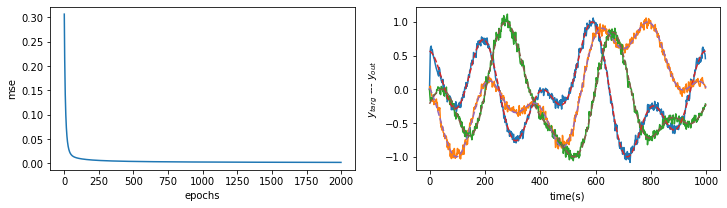

In [83]:
## Training RO

mse, Y = lttb.train_ro(par,out_epochs = 2000)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(mse)
plt.xlabel('epochs')
plt.ylabel('mse')

plt.subplot(122)
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()


0.09482713973161405
0.09332798097348266
0.08933138895341751
0.09463545596986368
0.07926578771626797
0.09061908070210001
0.10553204439134362
0.0791464443166847
0.09772144747541747
0.077165891397398
0.0907264670786508
0.08491951031110709
0.09075402708063549
0.0803085828841391
0.08372804977234345
0.07623548062003052
0.07981542650892438
0.08017540252804663
0.0755701454028642
0.08890391741220682


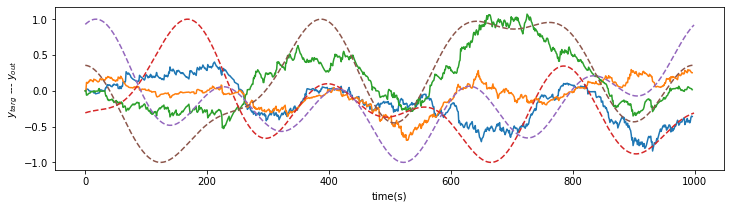

In [129]:
## Training Rec

gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 20

eta_out = 0.01
eta = 10.
etaW = .0

for iter in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation

    lttb.initialize(par)

    #run simulation
    dH = 0

    for t in range(lttb.T-2):
        
        lttb.step(apicalFactor = apicalFactorTrain)
        
        dH = dH*(1-dt/tau_m) + dt/tau_m*lttb.S_filt[:,t]
        #DJ = .2*np.outer(( lttb.B_filt[:,t+1] - lttb.B_filt_rec[:,t+1] ) ,dH)
        #DJ = np.outer(( S_apic_targ[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-S_apic_targ[:,t]) ,dH)
        DJ = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_dist[:,t]) ,dH)
        lttb.J =  lttb.J + eta*DJ 
        
        #SR = [:,1:-2]
        SR = lttb.B_filt_rec[:,t+1]
        Y = lttb.Jout@SR
        DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
        lttb.Jout =  lttb.Jout + eta_out*DJRO
    #print(DJ)
        
    ###### Test
    
    lttb.initialize(par)

    #run simulation

    for t in range(lttb.T-2):
        
        lttb.step(apicalFactor = apicalFactorTest)
        
    SR = lttb.B_filt_rec[:,1:-2]
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

plt.figure(figsize=(12, 3))
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()



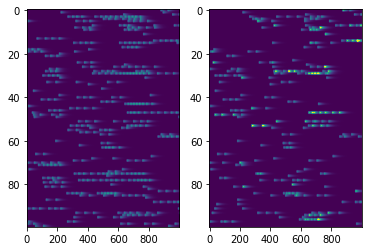

In [130]:
plt.figure()

plt.subplot(121)
plt.imshow(B_targ[0:100,:],aspect= 'auto')
plt.clim((0,.1))

plt.subplot(122)
plt.imshow(lttb.B_filt_rec[0:100,:],aspect= 'auto')
plt.clim((0,.1))


0.08890391741220682


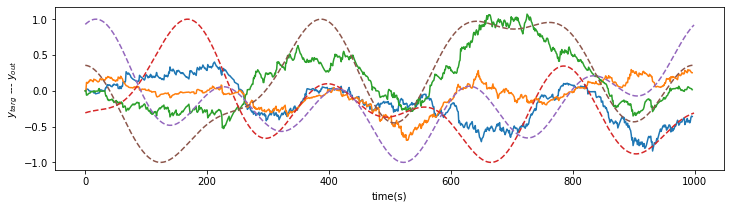

In [131]:
 ###### Test
    

#lttb.J = lttb.J *0
    
lttb.initialize(par)

    #run simulation

for t in range(lttb.T-2):
        
    lttb.step(apicalFactor = 0)
        
SR = (lttb.B_filt_rec[:,1:-2]+lttb.B_filt[:,1:-2])
Y = lttb.Jout@SR
mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

plt.figure(figsize=(12, 3))
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()

